# Goal:
Create a web app that analyzes and synthesizes 2 users' spotify recent taste profiles so that we can create a playlist filled with brand new song recommendations for both of them to discover together. The playlist we curate will automatically end up in both of their spotify libraries. Would be a cool new way for people to socialize because the playlist is unique to them and can create a special experience for both to find new music together that matches their music tastes.

### Some useful links to get started: 

spotipy documentation: https://spotipy.readthedocs.io/en/2.13.0/ 

github of guy who made this code (give proper credit later): https://github.com/makispl/Spotify-Data-Analysis

he also has a useful medium article that gives steps on how to use spotify api and this code: https://towardsdatascience.com/can-a-data-scientist-replace-a-dj-spotify-manipulation-with-python-fbbd4a45ffd5

I've also created an app on spotify developers already and this is the client id: 0b2103231ba64a70885c27fbb38cfa97
and this is the client secret: 45d7d10e11474298abcb52df745e2b25

### initial plan
for now, ive been thinking about combining both users' song histories as one big dataframe and then create 3-5 main clusters (basically types of music taste). each song can be grouped into a cluster depending on its song features. once we have the clusters, we can then search the whole spotify database for the top 20-30 songs that have the closest euclidean distance from the main clusters + any other filters that could be like must have at least 50k streams already or cannot be a song thats featured on any popular spotify playlists.

Below is the guy's code and i started tweaking a few things like entering the app's client id and client secret into some of the code, but largely left everything as is for now.

In [133]:
# Import the libraries
import os
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns
%config InlineBackend.figure_format ='retina'
import spotipy
import spotipy.util as util

from spotipy.oauth2 import SpotifyClientCredentials

## Authorization Flow

In [134]:
# Declare the credentials
cid = '0b2103231ba64a70885c27fbb38cfa97'
secret = '45d7d10e11474298abcb52df745e2b25'
redirect_uri='http://localhost:7777/callback'
username = 'trustinyoon'

In [135]:
# Authorization flow
scope = 'user-top-read'
token = util.prompt_for_user_token(username, scope, client_id=cid, client_secret=secret, redirect_uri=redirect_uri)

if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)

## Extract User's Top Medium Term Songs

In [136]:
# Fetch the top-50 songs of the user (medium term)
if token:
    sp = spotipy.Spotify(auth=token)
    results = sp.current_user_top_tracks(limit=50,offset=0,time_range='medium_term')
    for song in range(50):
        list = []
        list.append(results)
        with open('top50_data.json', 'w', encoding='utf-8') as f:
            json.dump(list, f, ensure_ascii=False, indent=4)
else:
    print("Can't get token for", username)
    
# Open the JSON file to Python objects
with open('top50_data.json') as f:
  data = json.load(f)

len(data[0]['items'])

50

In [137]:
list_of_results = data[0]["items"]
list_of_artist_names = []
list_of_artist_uri = []
list_of_song_names = []
list_of_song_uri = []
list_of_durations_ms = []
list_of_explicit = []
list_of_albums = []
list_of_popularity = []

for result in list_of_results:
    result["album"]
    this_artists_name = result["artists"][0]["name"]
    list_of_artist_names.append(this_artists_name)
    this_artists_uri = result["artists"][0]["uri"]
    list_of_artist_uri.append(this_artists_uri)
    list_of_songs = result["name"]
    list_of_song_names.append(list_of_songs)
    song_uri = result["uri"]
    list_of_song_uri.append(song_uri)
    list_of_duration = result["duration_ms"]
    list_of_durations_ms.append(list_of_duration)
    song_explicit = result["explicit"]
    list_of_explicit.append(song_explicit)
    this_album = result["album"]["name"]
    list_of_albums.append(this_album)
    song_popularity = result["popularity"]
    list_of_popularity.append(song_popularity)

In [138]:
# Convert the pulled content to a pandas df
all_songs = pd.DataFrame(
    {'artist': list_of_artist_names,
     'artist_uri': list_of_artist_uri,
     'song': list_of_song_names,
     'song_uri': list_of_song_uri,
     'duration_ms': list_of_durations_ms,
     'explicit': list_of_explicit,
     'album': list_of_albums,
     'popularity': list_of_popularity
     
    })

In [139]:
all_songs.sort_values('popularity', ascending=False).head(3)

,artist,artist_uri,song,song_uri,duration_ms,explicit,album,popularity
47,The Weeknd,spotify:artist:1Xyo4u8uXC1ZmMpatF05PJ,Blinding Lights,spotify:track:0VjIjW4GlUZAMYd2vXMi3b,200040,False,After Hours,99
12,Roddy Ricch,spotify:artist:757aE44tKEUQEqRuT6GnEB,The Box,spotify:track:0nbXyq5TXYPCO7pr3N8S4I,196652,True,Please Excuse Me For Being Antisocial,94
31,Pop Smoke,spotify:artist:0eDvMgVFoNV3TpwtrVCoTj,Dior,spotify:track:79s5XnCN4TJKTVMSmOx8Ep,216386,True,Meet The Woo,85


#### Extract Users' Top 50 Tracks' Audio Features

In [140]:
top50_list = []
for song in all_songs['song_uri']:
    row = pd.DataFrame(sp.audio_features(tracks=[song]))
    top50_list.append(row)
top50_df = pd.concat(top50_list)
top50_df.head(3)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,0.817,0.656,10,-7.086,0,0.277,0.051,0.0,0.115,0.314,139.915,audio_features,0AhJag7VI8uFf3mJFsTwvf,spotify:track:0AhJag7VI8uFf3mJFsTwvf,https://api.spotify.com/v1/tracks/0AhJag7VI8uF...,https://api.spotify.com/v1/audio-analysis/0AhJ...,120076,4
0,0.771,0.654,8,-6.976,0,0.298,0.055,0.0,0.214,0.573,155.047,audio_features,56uXDJRCuoS7abX3SkzHKQ,spotify:track:56uXDJRCuoS7abX3SkzHKQ,https://api.spotify.com/v1/tracks/56uXDJRCuoS7...,https://api.spotify.com/v1/audio-analysis/56uX...,224955,4
0,0.594,0.676,2,-5.808,1,0.344,0.135,0.0,0.163,0.472,143.477,audio_features,40mjsnRjCpycdUw3xhS20g,spotify:track:40mjsnRjCpycdUw3xhS20g,https://api.spotify.com/v1/tracks/40mjsnRjCpyc...,https://api.spotify.com/v1/audio-analysis/40mj...,181145,4


In [141]:
top50_df.drop(['type','track_href','analysis_url','time_signature','duration_ms'],1,inplace=True)
top50_df.head(1)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id,uri
0,0.817,0.656,10,-7.086,0,0.277,0.051,0.0,0.115,0.314,139.915,0AhJag7VI8uFf3mJFsTwvf,spotify:track:0AhJag7VI8uFf3mJFsTwvf


In [142]:
top50_df.describe()

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
count,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000,50.000000
mean,0.673000,0.683096,5.600000,-7.415720,0.580000,0.252458,0.183785,0.115540,0.275102,0.511720,120.321320
std,0.159776,0.162146,3.875617,6.859086,0.498569,0.139431,0.201023,0.267523,0.211855,0.215136,29.994081
min,0.147000,0.008780,0.000000,-53.613000,0.000000,0.028600,0.000592,0.000000,0.054700,0.026000,70.776000
25%,0.565250,0.585250,1.000000,-7.425000,0.000000,0.125000,0.033325,0.000000,0.107500,0.346500,91.162250
50%,0.664500,0.695000,7.000000,-6.320000,1.000000,0.273500,0.117000,0.000000,0.213000,0.504500,125.963000
75%,0.801000,0.805000,9.000000,-5.615750,1.000000,0.350250,0.232250,0.001170,0.359750,0.667750,139.895000
max,0.929000,0.912000,11.000000,-2.764000,1.000000,0.490000,0.899000,0.943000,0.834000,0.974000,177.728000


In [143]:
top50_df.drop('uri',1,inplace=True)
top50_df.head(1)

,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,id
0,0.817,0.656,10,-7.086,0,0.277,0.051,0.0,0.115,0.314,139.915,0AhJag7VI8uFf3mJFsTwvf


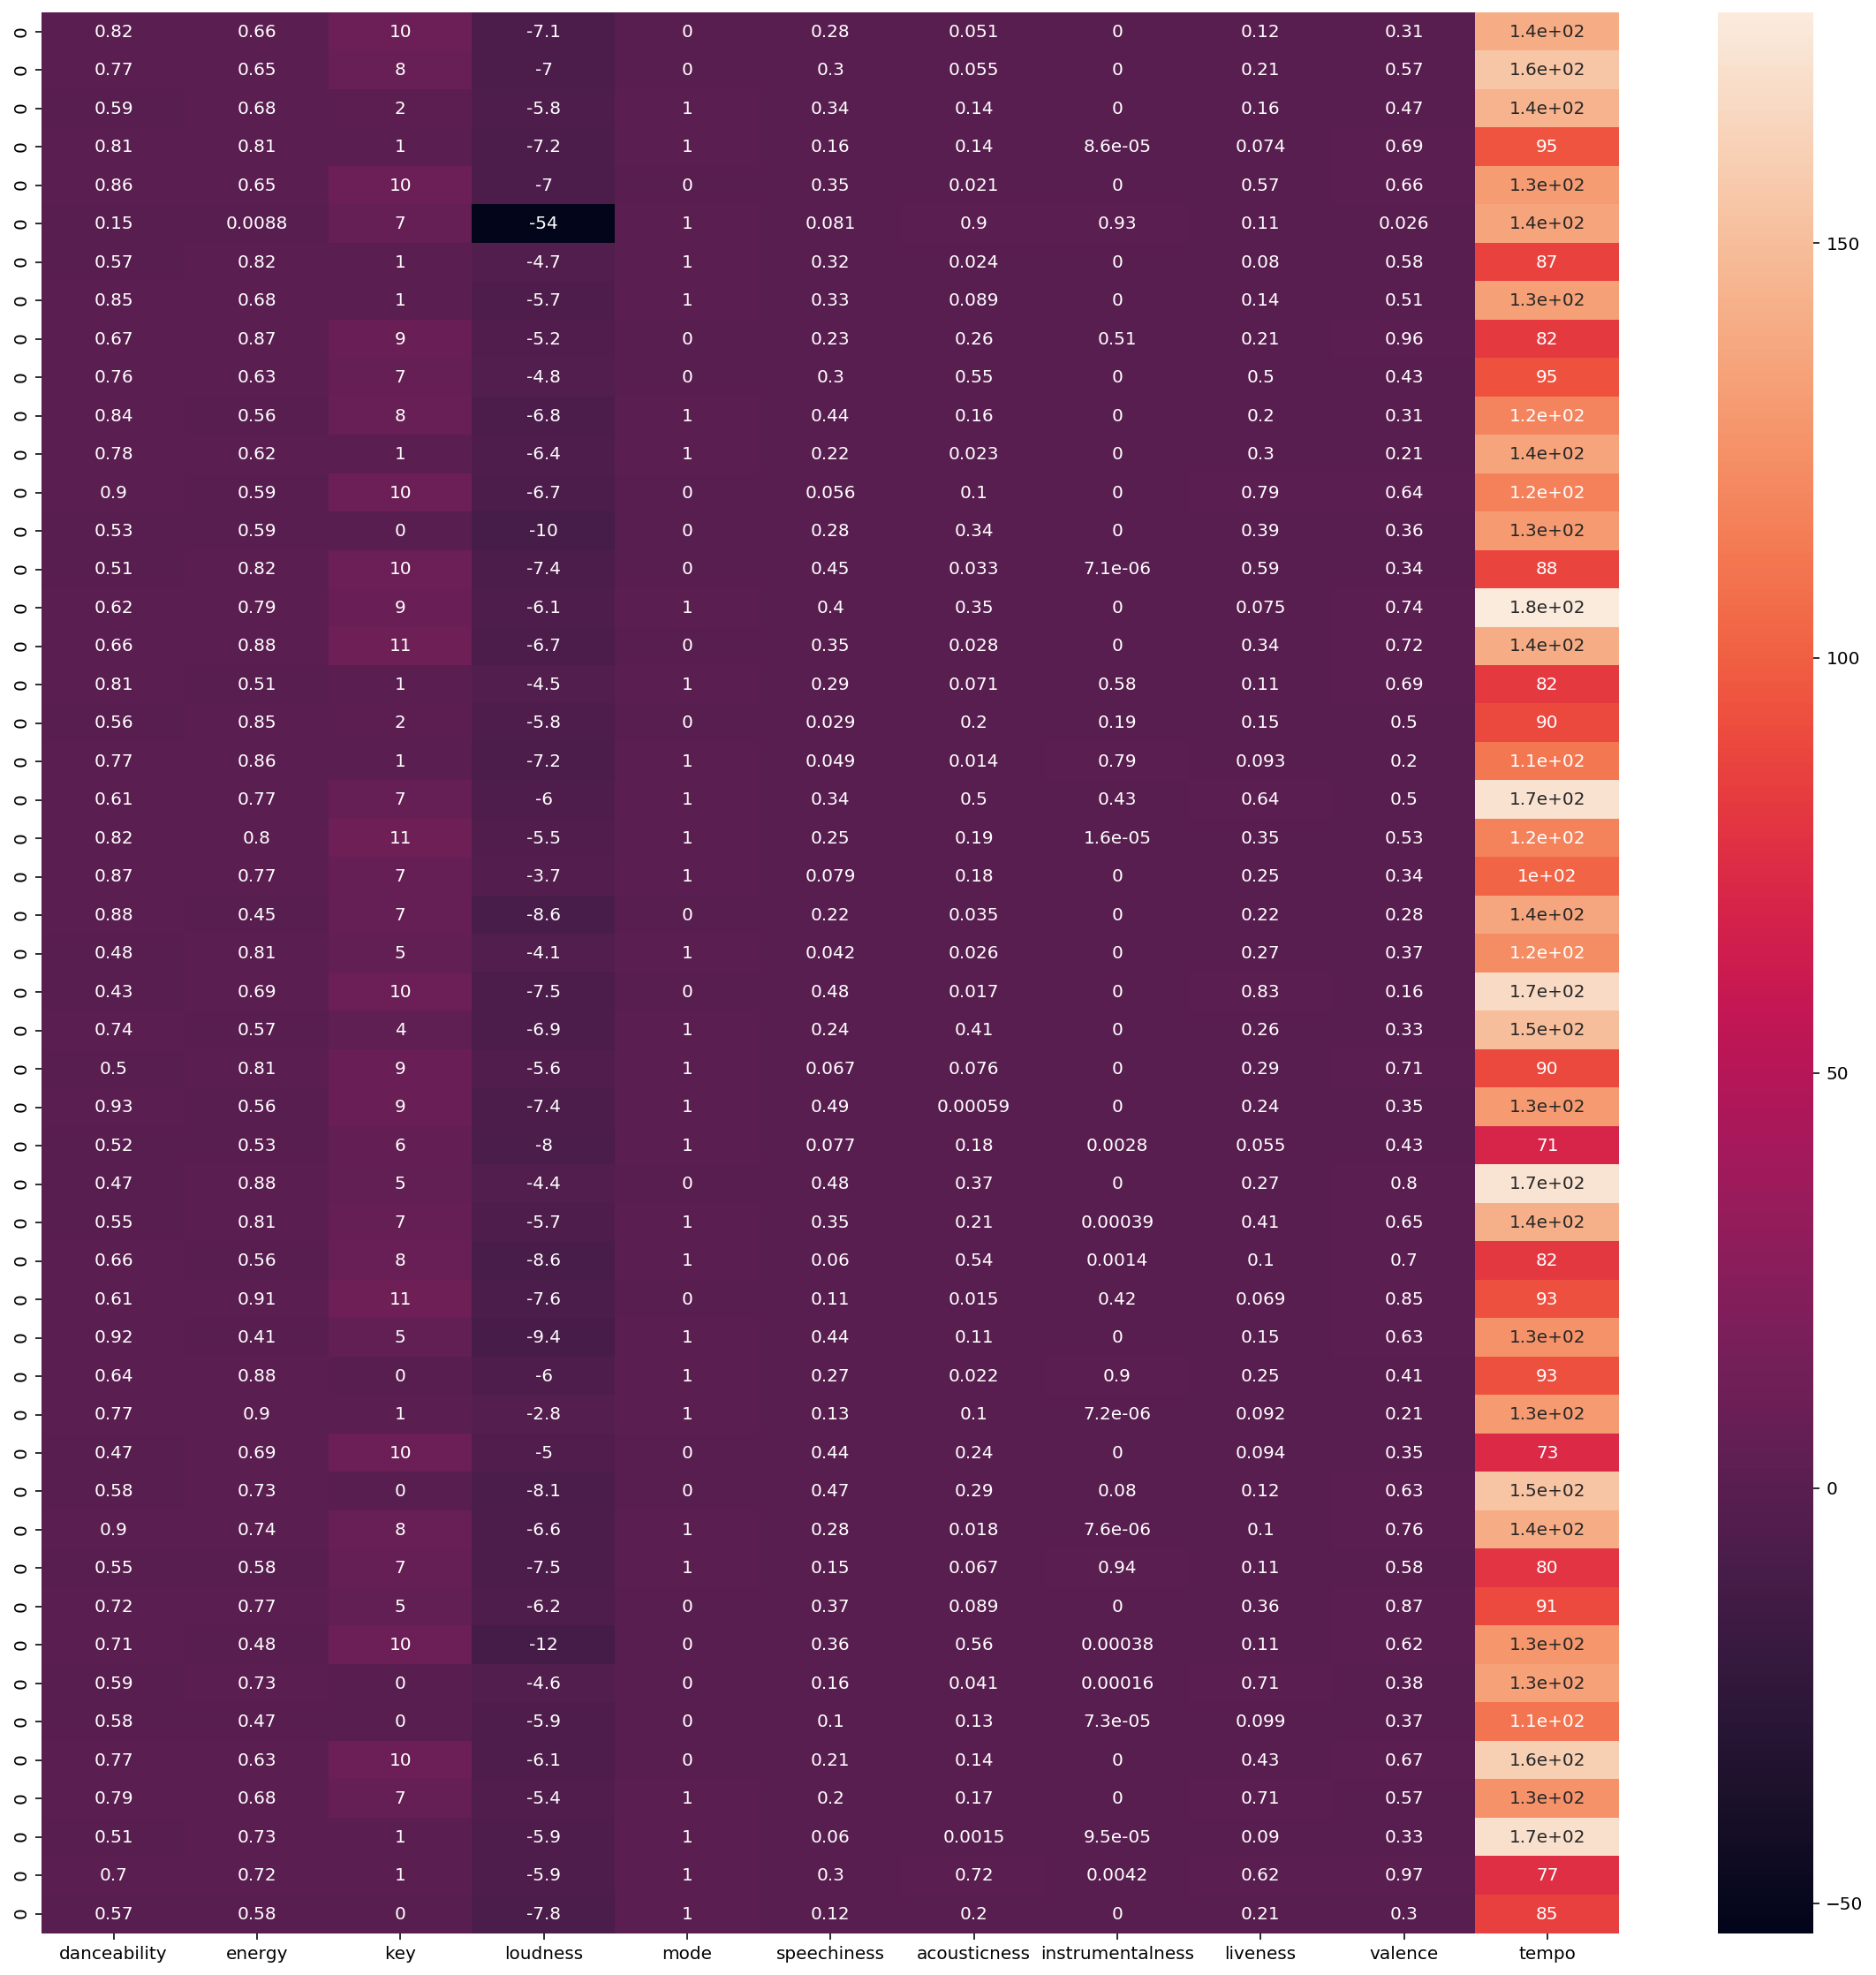

In [151]:
plt.figure(figsize=(20,20))
sns.heatmap(data=top50_df.drop('id',1),annot=True)

-------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------

-------------------------------------------------------------------------------------------

------------------------------------------------------------------------------------------

## Extract the User Playlists
hold off playlist data for now to simplify clusters to only top 50 songs

In [158]:
# Fetch the user's playlists
client_credentials_manager = SpotifyClientCredentials(client_id=cid, client_secret=secret) 
sp = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

playlists = sp.user_playlists(username)
for playlist in playlists['items']:
    print('Name: {}, Playlist ID: {}, No Tracks: {}'.
          format(playlist['name'], playlist['id'], playlist['tracks']['total']))

Name: 여, Playlist ID: 0V4FzMOSwDfXefUZMfB5ou, No Tracks: 6
Name: waH, Playlist ID: 0oC7KjO0OYwBZ7fGHRZDqs, No Tracks: 18
Name: some riffs, Playlist ID: 4KXwQmMq9mEhHNh80DwctY, No Tracks: 20
Name: dayman, Playlist ID: 63F4DtyuN7BYb3qdie0yA4, No Tracks: 62
Name: hesii filayy, Playlist ID: 0Yhf0Or6qZoh6EsYkI0gWP, No Tracks: 61
Name: freedo, Playlist ID: 0h5NY62KiEY1pmwZuJXG2I, No Tracks: 53
Name: quaranscenes, Playlist ID: 5nV2W0kBwvygmoDJnxifiu, No Tracks: 33
Name: stink, Playlist ID: 6tQ6Gc5IGaq3eS7ewuvvxl, No Tracks: 13
Name: not yandhi, Playlist ID: 7qup6JfzV0FNNclbPkaPmJ, No Tracks: 20
Name: greenwich pillage, Playlist ID: 2dOzrdib9dd2JDoH9aOMey, No Tracks: 28
Name: g'mawn, Playlist ID: 2noRplHAniMXA0qQL0sU1L, No Tracks: 65
Name: wtf an edm playlist, Playlist ID: 4i78ZzQuR59cvgs6L4m26C, No Tracks: 12
Name: 솔, Playlist ID: 7kERsbCgjzmBKlKbk9gGgY, No Tracks: 104
Name: 🌬💎🧬💦😳, Playlist ID: 7pOFL5iYPpZZKBnXTXvvLi, No Tracks: 28
Name: eLEVITATe, Playlist ID: 25RsI6ooU7py2iBfuaFlEP, No Trac

In [75]:
def fetch_playlists(sp, username):
    """
    Returns the user's playlists.
    """
        
    id = []
    name = []
    num_tracks = []
    
    # Make the API request
    playlists = sp.user_playlists(username)
    for playlist in playlists['items']:
        id.append(playlist['id'])
        name.append(playlist['name'])
        num_tracks.append(playlist['tracks']['total'])

    # Create the final df   
    df_playlists = pd.DataFrame({"id":id, "name": name, "#tracks": num_tracks})
    return df_playlists

### Extract Users Playlists' Tracks

In [122]:
def fetch_playlist_tracks(sp, username, playlist_id):
    """
    Returns the tracks for the given playlist.
    """
        
    offset = 0
    tracks = []
    
    # Make the API request
    while True:
        content = sp.user_playlist_tracks(username, playlist_id, fields=None, limit=100, offset=offset, market=None)
        tracks += content['items']
        
        if content['next'] is not None:
            offset += 100
        else:
            break
    
    track_id = []
    track_name = []
    
    for track in tracks:
        track_id.append(track['track']['id'])
        track_name.append(track['track']['name'])
    
    # Create the final df
    df_playlists_tracks = pd.DataFrame({"track_id":track_id, "track_name": track_name})
    return df_playlists_tracks

In [154]:
#list of user's 5 most recent playlists
last_5_playlists = fetch_playlists(sp,username).iloc[:5]
five = last_5_playlists.id.to_list()

#### Extract User Playlist Tracks' Audio Features

In [144]:
def fetch_audio_features(sp, username, playlist_id):
    playlist = fetch_playlist_tracks(sp, username, playlist_id)
    index = 0
    audio_features = []
    
    while index < playlist.shape[0]:
        audio_features += sp.audio_features(playlist.iloc[index:index + 50, 0])
        index += 50
    
    features_list = []
    for features in audio_features:
        features_list.append([features['danceability'],
                              features['energy'], features['tempo'],
                              features['loudness'], features['valence'],
                              features['speechiness'], features['instrumentalness'],
                              features['liveness'], features['acousticness']])
    
    df_audio_features = pd.DataFrame(features_list, columns=['danceability', 'energy',
                                                             'tempo', 'loudness', 'valence',
                                                             'speechiness', 'instrumentalness',
                                                             'liveness', 'acousticness'])
    
    df_playlist_audio_features = pd.concat([playlist, df_audio_features], axis=1)
    df_playlist_audio_features.set_index('track_id', inplace=True, drop=True)
        
    return df_playlist_audio_features

In [156]:
#testing
df = fetch_audio_features(sp,username,"0V4FzMOSwDfXefUZMfB5ou")
df.head(3)

,track_name,danceability,energy,tempo,loudness,valence,speechiness,instrumentalness,liveness,acousticness
track_id,,,,,,,,,,
2FhwCqbGVkmLPlhpKpShP2,FACT,0.964,0.724,119.983,-5.692,0.888,0.252,0.000000,0.344,0.3620
6BANZxi4uJfJSFxvzHGpX2,SUPER STAR,0.744,0.718,129.961,-4.529,0.364,0.049,0.000002,0.045,0.0294
3Us7aZzRAmiAQ0fyfR1rfR,FXXK IT - KR Ver.,0.716,0.753,90.060,-3.030,0.560,0.123,0.000000,0.192,0.1620


## Create the New Playlist
Next, we are going to create a new playlist and add to it all the tracks we ended up selecting:

In [ ]:
# Authorization flow

scope = "playlist-modify-public"
token = util.prompt_for_user_token(username, scope, client_id=cid, client_secret=secret, redirect_uri=redirect_uri)

if token:
    sp = spotipy.Spotify(auth=token)
else:
    print("Can't get token for", username)

In [ ]:
def create_playlist(sp, username, playlist_name, playlist_description):
    playlists = sp.user_playlist_create(username, playlist_name, description = playlist_description)

In [ ]:
create_playlist(sp, username, 'Pandas Party', 'A pure party playlist created by DJ Pandas!')

In [ ]:
# Find the new playlist's id
fetch_playlists(sp,username)

In [122]:
def enrich_playlist(sp, username, playlist_id, playlist_tracks):
    index = 0
    results = []
    
    while index < len(playlist_tracks):
        results += sp.user_playlist_add_tracks(username, playlist_id, tracks = playlist_tracks[index:index + 100])
        index += 100

In [123]:
list_track = df_party_exp_III.index

In [126]:
enrich_playlist(sp, username, '779Uv1K6LcYiiWxblSDjx7', list_track)

SpotifyException: http status: 403, code:-1 - https://api.spotify.com/v1/users/11153510588/playlists/779Uv1K6LcYiiWxblSDjx7/tracks:
 Insufficient client scope

## Conclusion
We have come a long way so far; we processed hundreds of tracks, inspected their audio features and finally selected the most befitting for the party ones, using Python and only. In this way, we managed to accomplish the initially stated missions:

✔️ we demonstrated how plain (descriptive) statistics and coding - when properly combined - can figure out time-consuming activities like this.

✔️ we "tasted" (once again, after the previous project of Twitter Sentiment Analysis on the next James Bond movie) the importance of having an API available to request, so as to extract meaningful data.
## Additional Analysis
There is quite a number of additional analyses to be performed, expanding this one. You are welcome to extend and shape yours in any direction you may prefer. For instance, you can additionally try and remove the tracks that have significantly low `danceability` and `valence` audio features, and boost even more the playlist's `score`. Furthemore, you can apply each approach sequentially (on the dataframe that is produced each time).